In [6]:
import os

# List input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/datasets
/kaggle/input/datasets/andrewmvd
/kaggle/input/datasets/andrewmvd/isic-2019
/kaggle/input/datasets/andrewmvd/isic-2019/ISIC_2019_Training_Input
/kaggle/input/datasets/andrewmvd/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input
/kaggle/input/notebooks
/kaggle/input/notebooks/ashfakyeafi
/kaggle/input/notebooks/ashfakyeafi/isic-2019
/kaggle/input/notebooks/ashfakyeafi/isic-2019/__results___files


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [8]:
BASE_PATH = "/kaggle/input/datasets/andrewmvd/isic-2019"

df = pd.read_csv(f"{BASE_PATH}/ISIC_2019_Training_GroundTruth.csv")

df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
print("Dataset Shape:", df.shape)

Dataset Shape: (25331, 10)


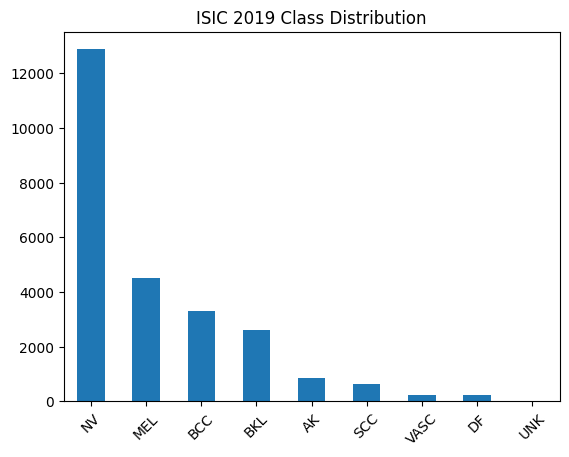

NV      12875.0
MEL      4522.0
BCC      3323.0
BKL      2624.0
AK        867.0
SCC       628.0
VASC      253.0
DF        239.0
UNK         0.0
dtype: float64


In [10]:
#checking class distribution
class_columns = df.columns[1:]  # Exclude image name

class_counts = df[class_columns].sum().sort_values(ascending=False)

plt.figure()
class_counts.plot(kind='bar')
plt.title("ISIC 2019 Class Distribution")
plt.xticks(rotation=45)
plt.show()

print(class_counts)


In [11]:
df['label'] = df[class_columns].idxmax(axis=1)

df = df[['image', 'label']]

df.head()

,image,label
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


In [12]:
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])

print("Classes:", le.classes_)

label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mapping)

Classes: ['AK' 'BCC' 'BKL' 'DF' 'MEL' 'NV' 'SCC' 'VASC']
{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}


In [13]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['encoded_label'],
    random_state=42
)

print("Train:", train_df.shape)
print("Validation:", val_df.shape)

Train: (20264, 3)
Validation: (5067, 3)


**PreProcessing**

In [16]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [37]:
#augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.1,
        hue=0.02
    ),
    
    transforms.ToTensor(),
    
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [38]:
#validation transform
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [33]:
#Custom Dataset Class
class ISICDataset(Dataset):
    def __init__(self, dataframe, image_path, transform=None):
        self.df = dataframe
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image']
        label = self.df.iloc[idx]['encoded_label']

        img = Image.open(f"{self.image_path}/{img_name}.jpg").convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

In [34]:
class_counts = train_df['encoded_label'].value_counts().sort_index()
class_weights = 1.0 / class_counts
class_weights = torch.tensor(class_weights.values, dtype=torch.float)
class_weights = class_weights.to(device)

print(class_weights)

tensor([1.4409e-03, 3.7622e-04, 4.7642e-04, 5.2356e-03, 2.7640e-04, 9.7087e-05,
        1.9920e-03, 4.9505e-03], device='cuda:0')


In [35]:
IMAGE_PATH = f"{BASE_PATH}/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

train_dataset = ISICDataset(train_df, IMAGE_PATH, transform=train_transforms)
val_dataset = ISICDataset(val_df, IMAGE_PATH, transform=val_transforms)

In [36]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)


**Training**

In [43]:
!pip install -q timm
import timm

In [44]:
model = timm.create_model(
    'efficientnet_b3',
    pretrained=True,
    num_classes=len(le.classes_)
)

model = model.to(device)

print("Model Loaded ✅")

Model Loaded ✅


In [45]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [46]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

In [47]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10
)

In [48]:
scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_55/2340218076.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [49]:
from tqdm import tqdm

def train_one_epoch(model, loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy

In [66]:
from sklearn.metrics import balanced_accuracy_score
import numpy as np

def validate(model, loader):
    model.eval()
    running_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(loader)
    val_acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    val_bal_acc = 100 * balanced_accuracy_score(all_labels, all_preds)

    return val_loss, val_acc, val_bal_acc

In [52]:
from sklearn.metrics import balanced_accuracy_score
import numpy as np
import torch

best_val_acc = 0
EPOCHS = 15  

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # ---- TRAIN ----
    train_loss, train_acc = train_one_epoch(model, train_loader)

    # ---- VALIDATE ----
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    val_bal_acc = 100 * balanced_accuracy_score(all_labels, all_preds)

    scheduler.step()

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Balanced Acc: {val_bal_acc:.2f}%")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_isic_model.pth")
        print("Best model savedddddd!")



Epoch 1/15


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [05:39<00:00,  1.87it/s]


Train Loss: 1.6656 | Train Acc: 47.50%
Val Loss: 1.1563 | Val Acc: 57.08% | Balanced Acc: 58.85%
🔥 Best model saved!

Epoch 2/15


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:41<00:00,  2.86it/s]


Train Loss: 0.9863 | Train Acc: 63.03%
Val Loss: 0.9867 | Val Acc: 59.58% | Balanced Acc: 63.57%
🔥 Best model saved!

Epoch 3/15


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:44<00:00,  2.82it/s]


Train Loss: 0.7911 | Train Acc: 68.71%
Val Loss: 0.9238 | Val Acc: 69.45% | Balanced Acc: 66.31%
🔥 Best model saved!

Epoch 4/15


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:43<00:00,  2.83it/s]


Train Loss: 0.6482 | Train Acc: 72.36%
Val Loss: 0.8753 | Val Acc: 72.11% | Balanced Acc: 69.58%
🔥 Best model saved!

Epoch 5/15


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:42<00:00,  2.85it/s]


Train Loss: 0.5018 | Train Acc: 77.08%
Val Loss: 0.8574 | Val Acc: 73.26% | Balanced Acc: 72.07%
🔥 Best model saved!

Epoch 6/15


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:45<00:00,  2.81it/s]


Train Loss: 0.4246 | Train Acc: 79.72%
Val Loss: 0.8978 | Val Acc: 73.79% | Balanced Acc: 70.89%
🔥 Best model saved!

Epoch 7/15


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:44<00:00,  2.82it/s]


Train Loss: 0.3366 | Train Acc: 82.39%
Val Loss: 0.8873 | Val Acc: 76.14% | Balanced Acc: 72.44%
🔥 Best model saved!

Epoch 8/15


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:44<00:00,  2.83it/s]


Train Loss: 0.2947 | Train Acc: 84.45%
Val Loss: 0.8978 | Val Acc: 76.14% | Balanced Acc: 72.55%

Epoch 9/15


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:44<00:00,  2.82it/s]


Train Loss: 0.2520 | Train Acc: 86.02%
Val Loss: 0.9112 | Val Acc: 77.24% | Balanced Acc: 72.12%
🔥 Best model saved!

Epoch 10/15


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:45<00:00,  2.82it/s]


Train Loss: 0.2341 | Train Acc: 86.67%
Val Loss: 0.8815 | Val Acc: 76.36% | Balanced Acc: 73.23%

Epoch 11/15


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:44<00:00,  2.82it/s]


Train Loss: 0.2297 | Train Acc: 86.99%
Val Loss: 0.9042 | Val Acc: 77.21% | Balanced Acc: 72.92%

Epoch 12/15


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:44<00:00,  2.82it/s]


Train Loss: 0.2328 | Train Acc: 86.86%
Val Loss: 0.8933 | Val Acc: 77.52% | Balanced Acc: 73.13%
🔥 Best model saved!

Epoch 13/15


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:43<00:00,  2.84it/s]


Train Loss: 0.2326 | Train Acc: 86.66%
Val Loss: 0.8913 | Val Acc: 77.92% | Balanced Acc: 74.51%
🔥 Best model saved!

Epoch 14/15


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:42<00:00,  2.85it/s]


Train Loss: 0.2332 | Train Acc: 86.66%
Val Loss: 0.9210 | Val Acc: 77.60% | Balanced Acc: 73.01%

Epoch 15/15


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:45<00:00,  2.82it/s]


Train Loss: 0.2231 | Train Acc: 87.37%
Val Loss: 0.9394 | Val Acc: 76.79% | Balanced Acc: 71.85%


In [53]:
model.load_state_dict(torch.load("best_isic_model.pth"))
model.eval()

print("Best model loaded ✅")

torch.save(model.state_dict(), "/kaggle/working/final_isic_model.pth")
print("Model saved successfully ✅")



Best model loaded ✅
Model saved successfully ✅


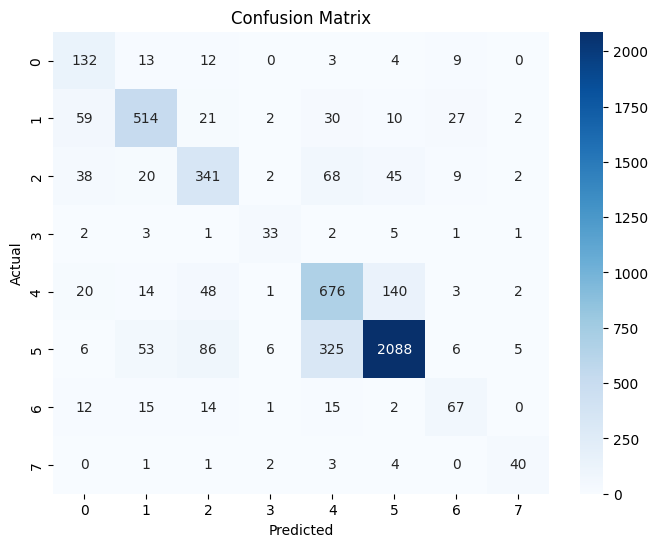

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [56]:
import os
print(os.listdir("/kaggle/working"))

['.virtual_documents', 'final_isic_model.pth', 'best_isic_model.pth']


**Fine Tuning Increasing Accuracy**

In [57]:
import torch
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model(
    'efficientnet_b3',
    pretrained=False,
    num_classes=8
)

model.load_state_dict(torch.load("/kaggle/working/best_isic_model.pth"))
model = model.to(device)
model.eval()

print("Best ISIC model loaded ✅")


Best ISIC model loaded ✅


In [58]:
import torchvision.transforms as transforms
import torch.nn.functional as F

tta_transforms = [
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],
                             [0.229,0.224,0.225])
    ]),
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],
                             [0.229,0.224,0.225])
    ])
]

In [61]:
import torch.nn.functional as F

def evaluate_with_tta(model, dataset):
    model.eval()
    correct = 0
    total = 0

    for idx in range(len(dataset)):
        # Get original image path manually
        img_name = dataset.df.iloc[idx]['image']
        label = dataset.df.iloc[idx]['encoded_label']

        img = Image.open(f"{IMAGE_PATH}/{img_name}.jpg").convert("RGB")

        predictions = []

        for t in tta_transforms:
            input_tensor = t(img).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor)
                prob = F.softmax(output, dim=1)

            predictions.append(prob)

        avg_prediction = torch.mean(torch.stack(predictions), dim=0)
        pred_class = torch.argmax(avg_prediction, dim=1)

        correct += (pred_class.item() == label)
        total += 1

    print("TTA Accuracy:", 100 * correct / total)


In [62]:
evaluate_with_tta(model, val_dataset)

TTA Accuracy: 78.96191040063154


In [63]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6, weight_decay=1e-4)

EPOCHS_FINE = 10

In [64]:
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

In [67]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-6,   # very small
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=5
)
EPOCHS_FINE = 5
best_val_acc = 0

for epoch in range(EPOCHS_FINE):
    print(f"\nFine Tune Epoch {epoch+1}/{EPOCHS_FINE}")

    train_loss, train_acc = train_one_epoch(model, train_loader)

    val_loss, val_acc, val_bal_acc = validate(model, val_loader)

    scheduler.step()

    print(f"Train Acc: {train_acc:.2f}%")
    print(f"Val Acc: {val_acc:.2f}% | Balanced Acc: {val_bal_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/best_isic_finetuned.pth")
        print("🔥 Best Fine-Tuned Model Saved")



Fine Tune Epoch 1/5


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:38<00:00,  2.90it/s]


Train Acc: 89.08%
Val Acc: 79.24% | Balanced Acc: 68.10%
🔥 Best Fine-Tuned Model Saved

Fine Tune Epoch 2/5


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:39<00:00,  2.89it/s]


Train Acc: 89.28%
Val Acc: 79.93% | Balanced Acc: 68.20%
🔥 Best Fine-Tuned Model Saved

Fine Tune Epoch 3/5


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:40<00:00,  2.88it/s]


Train Acc: 89.69%
Val Acc: 80.19% | Balanced Acc: 67.43%
🔥 Best Fine-Tuned Model Saved

Fine Tune Epoch 4/5


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:37<00:00,  2.92it/s]


Train Acc: 89.80%
Val Acc: 80.17% | Balanced Acc: 68.36%

Fine Tune Epoch 5/5


  0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_55/2489631559.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 634/634 [03:40<00:00,  2.88it/s]


Train Acc: 90.50%
Val Acc: 80.38% | Balanced Acc: 67.95%
🔥 Best Fine-Tuned Model Saved


# Making it good for research tryin to improve the balance accuracy



In [ ]:
model.load_state_dict(torch.load("/kaggle/working/best_isic_model.pth"))
model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

# using weighted sampler
from torch.utils.data import WeightedRandomSampler

targets = train_df['encoded_label'].values
class_sample_counts = np.bincount(targets)

weights = 1.0 / class_sample_counts
sample_weights = weights[targets]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=sampler,
    num_workers=2
)

In [ ]:
# Track Per-Class Metrics
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=le.classes_))

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

**Increasing Accuracy More detail(hope it works)**

In [27]:
import torch
import timm
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create SAME architecture
model = timm.create_model(
    'efficientnet_b3',
    pretrained=False,
    num_classes=8
)

# Load weights safely
state_dict = torch.load("/kaggle/input/models/rushikeshbhabad/isic-fined-tuned/pytorch/default/1/best_isic_finetuned.pth", map_location=device)
model.load_state_dict(state_dict)

model = model.to(device)
model.eval()

print("✅ EfficientNet-B3 loaded successfully")

✅ EfficientNet-B3 loaded successfully


In [28]:
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            with torch.amp.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                outputs = model(images)

            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)

    return acc, bal_acc, all_labels, all_preds

In [37]:
val_acc, val_bal_acc, labels, preds = evaluate_model(model, val_loader, device)

print(f"\nValidation Accuracy: {val_acc*100:.2f}%")
print(f"Balanced Accuracy:   {val_bal_acc*100:.2f}%")

print("\nClassification Report:\n")
print(classification_report(labels, preds, digits=4))


Validation Accuracy: 80.36%
Balanced Accuracy:   67.95%

Classification Report:

              precision    recall  f1-score   support

           0     0.6534    0.6647    0.6590       173
           1     0.8006    0.8451    0.8222       665
           2     0.7523    0.6133    0.6758       525
           3     0.7419    0.4792    0.5823        48
           4     0.7247    0.6350    0.6769       904
           5     0.8479    0.9219    0.8833      2575
           6     0.7126    0.4921    0.5822       126
           7     0.7843    0.7843    0.7843        51

    accuracy                         0.8036      5067
   macro avg     0.7522    0.6795    0.7083      5067
weighted avg     0.7981    0.8036    0.7980      5067



In [43]:
import torch
import timm
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

# ---------------- DEVICE ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- MODEL ----------------
model = timm.create_model(
    'efficientnet_b3',
    pretrained=False,
    num_classes=8
)

state_dict = torch.load("/kaggle/input/models/rushikeshbhabad/isic-fined-tuned/pytorch/default/1/best_isic_finetuned.pth", map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

print("✅ EfficientNet-B3 loaded successfully\n")

# ---------------- CLASS DISTRIBUTION ----------------
# AK, BCC, BKL, DF, MEL, NV, SCC, VASC
class_counts = np.array([867,3323,2624,239,4522,12875,628,253])

class_freq = class_counts / class_counts.sum()
class_weights = 1.0 / class_freq
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# ---------------- EVALUATION FUNCTION ----------------
def evaluate(model, loader, device, class_weights=None, alpha=0.0):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            with torch.amp.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                outputs = model(images)

            # Apply controlled logit adjustment
            if class_weights is not None and alpha > 0:
                adjustment = alpha * torch.log(class_weights)
                outputs = outputs + adjustment

            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)

    return acc, bal_acc, all_labels, all_preds


# ---------------- BASELINE ----------------
base_acc, base_bal_acc, labels, preds = evaluate(model, val_loader, device)

print("🔹 BASELINE")
print(f"Accuracy: {base_acc:.4f}")
print(f"Balanced Accuracy: {base_bal_acc:.4f}\n")

# ---------------- ALPHA SEARCH ----------------
print("🔹 Searching Best Alpha...\n")

best_bal = 0
best_alpha = 0
best_acc = 0

for alpha in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    acc, bal_acc, _, _ = evaluate(model, val_loader, device, class_weights, alpha)

    print(f"Alpha {alpha:.1f} -> Acc: {acc:.4f} | Bal Acc: {bal_acc:.4f}")

    if bal_acc > best_bal:
        best_bal = bal_acc
        best_alpha = alpha
        best_acc = acc

print("\n🔥 BEST RESULT")
print(f"Best Alpha: {best_alpha}")
print(f"Accuracy: {best_acc:.4f}")
print(f"Balanced Accuracy: {best_bal:.4f}")

# ---------------- CLASSIFICATION REPORT (BEST ALPHA) ----------------
_, _, labels, preds = evaluate(model, val_loader, device, class_weights, best_alpha)

print("\nClassification Report (Best Alpha):\n")
print(classification_report(labels, preds, digits=4))

✅ EfficientNet-B3 loaded successfully

🔹 BASELINE
Accuracy: 0.8036
Balanced Accuracy: 0.6795

🔹 Searching Best Alpha...

Alpha 0.0 -> Acc: 0.8036 | Bal Acc: 0.6795
Alpha 0.1 -> Acc: 0.7999 | Bal Acc: 0.6950
Alpha 0.2 -> Acc: 0.7965 | Bal Acc: 0.7067
Alpha 0.3 -> Acc: 0.7904 | Bal Acc: 0.7216
Alpha 0.4 -> Acc: 0.7819 | Bal Acc: 0.7371
Alpha 0.5 -> Acc: 0.7657 | Bal Acc: 0.7468

🔥 BEST RESULT
Best Alpha: 0.5
Accuracy: 0.7657
Balanced Accuracy: 0.7468

Classification Report (Best Alpha):

              precision    recall  f1-score   support

           0     0.4962    0.7514    0.5977       173
           1     0.7864    0.7970    0.7916       665
           2     0.7059    0.6400    0.6713       525
           3     0.2901    0.7917    0.4246        48
           4     0.7005    0.6416    0.6697       904
           5     0.8910    0.8318    0.8604      2575
           6     0.5342    0.6190    0.5735       126
           7     0.3151    0.9020    0.4670        51

    accuracy         